In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import seaborn as sns
from google.cloud import bigquery

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cities/ScienceCityLatLong.csv


In [40]:
import bq_helper
from bq_helper import BigQueryHelper
# https://www.kaggle.com/sohier/introduction-to-the-bq-helper-package
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")

Using Kaggle's public dataset BigQuery integration.


In [41]:
bq_assistant = BigQueryHelper("bigquery-public-data", "stackoverflow")
bq_assistant.list_tables()

Using Kaggle's public dataset BigQuery integration.


['badges',
 'comments',
 'post_history',
 'post_links',
 'posts_answers',
 'posts_moderator_nomination',
 'posts_orphaned_tag_wiki',
 'posts_privilege_wiki',
 'posts_questions',
 'posts_tag_wiki',
 'posts_tag_wiki_excerpt',
 'posts_wiki_placeholder',
 'stackoverflow_posts',
 'tags',
 'users',
 'votes']

In [4]:
# original query from https://www.kaggle.com/code/d4isdavid/stack-overflow-project 
    # edited to get user_id

query = """
SELECT 
  users.id AS `User ID`,
  users.display_name AS `Display Name`, 
  users.location AS Location,
  users.reputation AS Reputation,
  COUNT(comments.id) AS Count
FROM `bigquery-public-data.stackoverflow.users` AS users
INNER JOIN `bigquery-public-data.stackoverflow.comments` AS comments
  ON users.id = comments.user_id
WHERE users.id > 0
GROUP BY users.id, users.display_name, users.location, users.reputation
ORDER BY Count DESC
LIMIT 25;
"""

# query the data
top_users = stackOverflow.query_to_pandas_safe(query, max_gb_scanned=2)
top_users

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,User ID,Display Name,Location,Reputation,Count
0,1491895,Barmar,"Arlington, MA",694414,167475
1,22656,Jon Skeet,"Reading, United Kingdom",1357603,87006
2,1048572,Bergi,None,589324,79365
3,1144035,Gordon Linoff,"New York, United States",1211186,74579
4,440558,Some programmer dude,"Malmö, Sweden",385586,69749
5,17034,Hans Passant,"Madison, WI",904625,68212
6,505088,David Heffernan,"Ulverston, United Kingdom",591216,64719
7,3832970,Wiktor Stribiżew,"Warsaw, Poland",576960,63155
8,1415724,Funk Forty Niner,None,74341,59857
9,15168,Jonathan Leffler,"Colorado, USA",707030,59119


In [52]:
query = """

WITH top_commenters AS (
  SELECT 
    c.user_id,
    COUNT(*) AS comment_count
  FROM `bigquery-public-data.stackoverflow.comments` AS c
  GROUP BY user_id
  ORDER BY comment_count DESC
  LIMIT 25
)


SELECT
  u.id AS user_id,
  u.display_name,
  u.location,
  u.reputation,

  tc.comment_count,


  COUNT(DISTINCT p.id) AS post_count

FROM top_commenters tc
JOIN `bigquery-public-data.stackoverflow.users` AS u
    ON tc.user_id = u.id

LEFT JOIN `bigquery-public-data.stackoverflow.stackoverflow_posts` AS p
    ON p.owner_user_id = u.id

GROUP BY
  user_id, display_name, location, reputation, comment_count
ORDER BY tc.comment_count DESC;
"""

top_both = stackOverflow.query_to_pandas_safe(query, max_gb_scanned=5)
top_both

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning:

BigQuery Storage module not found, fetch data with the REST endpoint instead.



,user_id,display_name,location,reputation,comment_count,post_count
0,1491895,Barmar,"Arlington, MA",694414,167475,12544
1,22656,Jon Skeet,"Reading, United Kingdom",1357603,87006,33177
2,1048572,Bergi,None,589324,79365,6695
3,1144035,Gordon Linoff,"New York, United States",1211186,74579,27474
4,-1,Community,on the server farm,1,74550,11402
5,440558,Some programmer dude,"Malmö, Sweden",385586,69749,7072
6,17034,Hans Passant,"Madison, WI",904625,68212,15692
7,505088,David Heffernan,"Ulverston, United Kingdom",591216,64719,11609
8,3832970,Wiktor Stribiżew,"Warsaw, Poland",576960,63155,4348
9,1415724,Funk Forty Niner,None,74341,59857,2230


/tmp/ipykernel_38/3962600297.py:26: UserWarning:

FixedFormatter should only be used together with FixedLocator



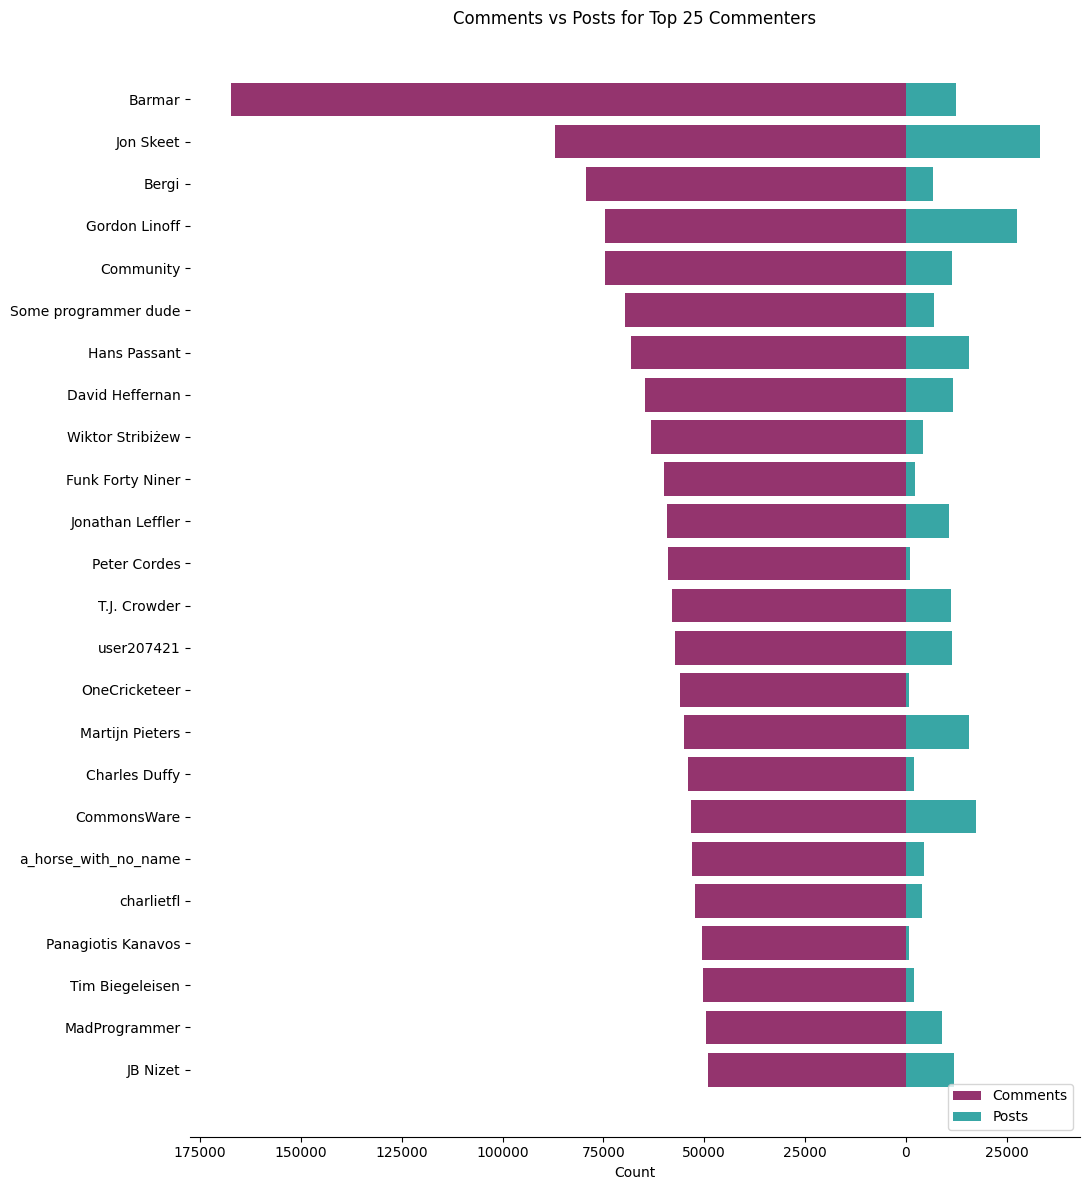

In [53]:
top_both = top_both.sort_values("comment_count", ascending=True)

users = top_both["display_name"]
comments = top_both["comment_count"]
posts = top_both["post_count"]

y = np.arange(len(top_both))

fig, ax = plt.subplots(figsize=(11, 12))


ax.barh(y, -comments, color="#94346E", label="Comments")


ax.barh(y, posts, color="#38A6A5", label="Posts")


ax.set_yticks(y)
ax.set_yticklabels(users)

xticks = ax.get_xticks()
ax.set_xticklabels([abs(int(t)) for t in xticks])


ax.set_xlabel("Count")
ax.set_title("Comments vs Posts for Top 25 Commenters")


for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)


ax.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [5]:
top_user_ids = top_users['User ID'].tolist()  # convert to list

# Create a string for SQL IN clause
top_user_ids_str = ",".join(map(str, top_user_ids))

top_comments_query = f"""
SELECT post_id, user_id, creation_date, text, score
FROM `bigquery-public-data.stackoverflow.comments`
WHERE user_id IN ({top_user_ids_str})
"""
top_comments = stackOverflow.query_to_pandas_safe(top_comments_query, max_gb_scanned=16)
top_comments

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,post_id,user_id,creation_date,text,score
0,30223641,14122,2017-01-18 16:44:18.107000+00:00,This really *is* the better answer. I'm a bit ...,17
1,40749968,14122,2016-11-22 19:30:57.833000+00:00,Hmm. There's a very nice answer in bash or ksh...,0
2,40747962,14122,2016-11-22 23:02:47.857000+00:00,Is the C helper I've built (and linked to from...,0
3,40755029,14122,2016-11-23 03:35:42.573000+00:00,"Why use `ls` at all, if you're expanding the g...",0
4,40772021,14122,2016-11-23 18:48:48.803000+00:00,"Even as amended, your `for` loop still runs on...",0
...,...,...,...,...,...
1586659,58668395,3832970,2019-11-02 10:01:06.220000+00:00,@skBangalore ``let reg = new RegExp(`^${curren...,2
1586660,58713334,3832970,2019-11-05 14:23:12.317000+00:00,[Your regex works](https://www.regexplanet.com...,2
1586661,57718199,3832970,2019-08-29 22:00:59.700000+00:00,"Use `/^\[\d+(?:,\d+)*]$/`",3
1586662,57869674,3832970,2019-09-10 11:19:19.200000+00:00,"`[A-z]` matches `[`, ``\``, `]`, `^`, `_`, `\`...",3


In [6]:
edges = []

# Group by post and create all pairs of users who commented on the same post
for post_id, group in top_comments.groupby('post_id'):
    users = group['user_id'].unique()
    # all combinations of 2 users
    for u1, u2 in combinations(users, 2):
        edges.append((u1, u2))


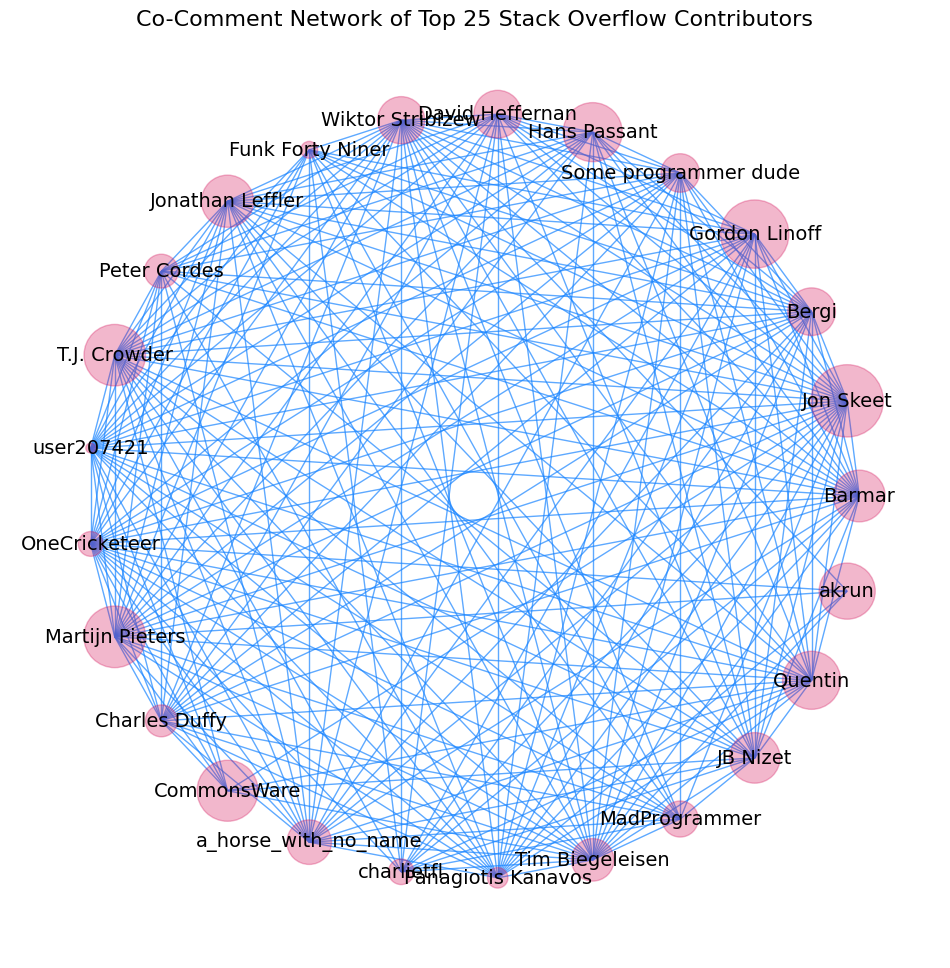

In [7]:
G = nx.Graph()

# Add nodes with attributes (label and reputation)
for _, row in top_users.iterrows():
    G.add_node(
        row['User ID'], 
        label=row['Display Name'],
        reputation=row['Reputation']
    )

# Add edges 
G.add_edges_from(edges)

reputations = [G.nodes[node]['reputation'] for node in G.nodes()]
node_sizes = [max(rep / 500, 50) for rep in reputations]  # scale and avoid zero size

plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)

# Draw nodes, scaling by reputation
nx.draw_networkx_nodes(
    G, pos,
    node_size=node_sizes,
    node_color="#D41159",
    alpha=0.3
)

# Draw edges
nx.draw_networkx_edges(
    G, pos,
    width=1,
    alpha=0.7,
    edge_color="#1A85FF"
)

# Draw labels
nx.draw_networkx_labels(
    G, pos,
    labels=nx.get_node_attributes(G, 'label'),
    font_size=14
)

plt.title("Co-Comment Network of Top 25 Stack Overflow Contributors", fontsize=16)
plt.axis('off')
plt.show()


In [8]:
top_comments["creation_date"] = pd.to_datetime(top_comments["creation_date"])

# Extract the day of week, month, year
top_comments["day_of_week"] = top_comments["creation_date"].dt.day_name()
top_comments["month"] = top_comments["creation_date"].dt.month_name()
top_comments["year"] = top_comments["creation_date"].dt.year


In [9]:
top_comments['comments_in_monthofyear'] = top_comments.groupby(['year', 'month']).transform('size')

In [10]:
top_comments["month_number"] = pd.to_datetime(top_comments["month"], format="%B").dt.month

In [11]:
top_comments['comments_in_monthofyear'] = top_comments.groupby(['year', 'month_number']).transform('size')

In [12]:
month_dict = {1: 'january',
              2: 'february',
              3: 'march',
              4: 'april',
              5: 'may',
              6: 'june',
              7: 'july',
              8: 'august',
              9: 'september',
              10: 'october',
              11: 'november',
              12: 'december'}

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

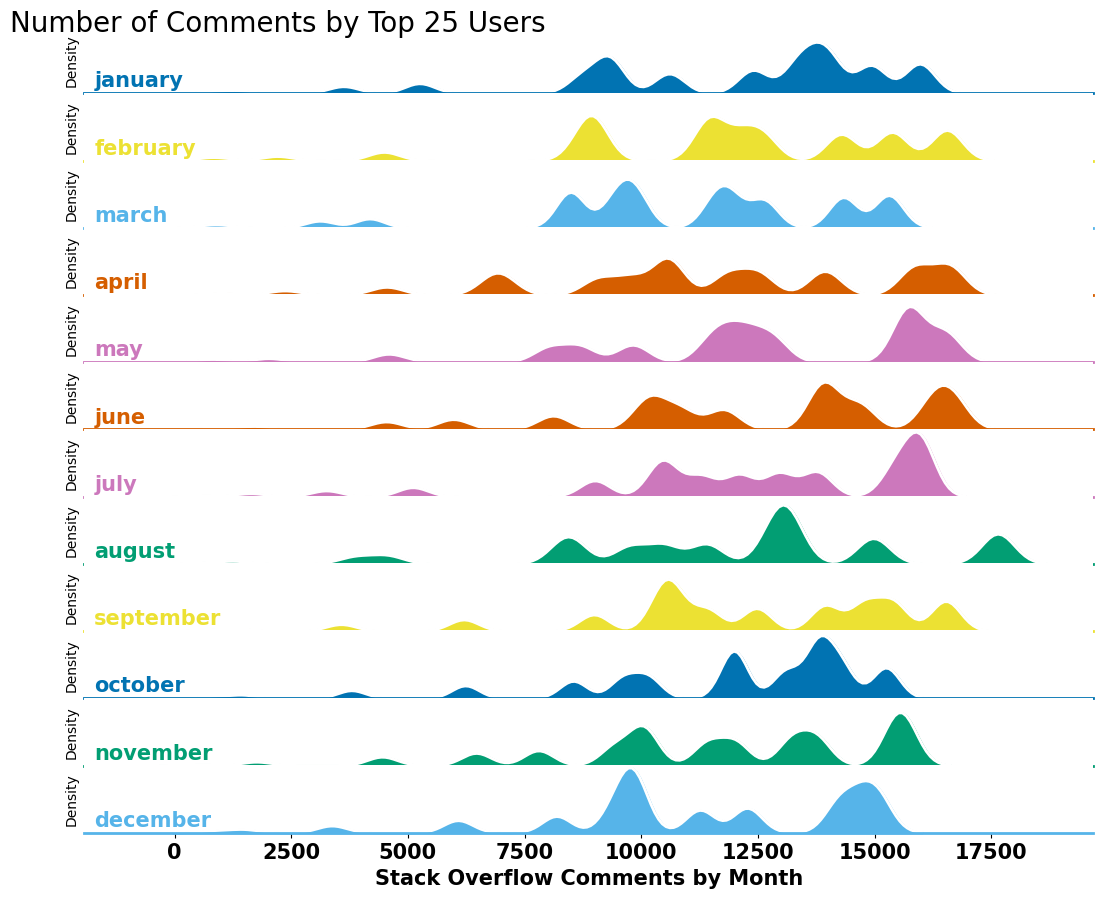

In [13]:
# code from Programming Lab


# we generate a color palette with Seaborn.color_palette() 
pal = sns.color_palette("colorblind6", 12)

# in the sns.FacetGrid class, the 'hue' argument is the one that is the one that will be represented by colors with 'palette' 
g = sns.FacetGrid(top_comments, row='month', hue='month_number', aspect=15, height=0.75, palette=pal)


# then we add the densities kdeplots for each month 
g.map(sns.kdeplot, 'comments_in_monthofyear', 
      bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=1.5) 
# here we add a white line that represents the contour of each kdeplot 
g.map(sns.kdeplot, 'comments_in_monthofyear', 
      bw_adjust=1, clip_on=False, color="w", lw=2)

# here we add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=2, clip_on=False)

# we loop over the FacetGrid figure axes (g.axes.flat) and add the month as text with the right color
# notice how ax.lines[-1].get_color() enables you to access the last line's color in each matplotlib.Axes
for i, ax in enumerate(g.axes.flat):
    ax.text(
        0.01, 0.1,                          # x, y in axes coords
        month_dict[i+1],
        fontweight='bold',
        fontsize=15,
        color=ax.lines[-1].get_color(),
        transform=ax.transAxes              
    )

# we use matplotlib.Figure.subplots_adjust() function to get the subplots to overlap
g.fig.subplots_adjust(hspace=-0.01)

# eventually we remove axes titles, yticks and spines
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.setp(ax.get_xticklabels(), fontsize=15, fontweight='bold')
plt.xlabel('Stack Overflow Comments by Month', fontweight='bold', fontsize=15)
g.fig.suptitle('Number of Comments by Top 25 Users',
               ha='right',
               fontsize=20,
               fontweight=20)

plt.show()

In [14]:
top_badges_query = f"""
SELECT user_id, count(id) AS badge_count
FROM `bigquery-public-data.stackoverflow.badges`
WHERE user_id IN ({top_user_ids_str})
GROUP BY user_id
ORDER BY badge_count DESC
"""

In [15]:
# query the data
top_badges = stackOverflow.query_to_pandas_safe(top_badges_query, max_gb_scanned=2)
top_badges

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,user_id,badge_count
0,22656,18900
1,100297,7387
2,115145,4918
3,17034,4269
4,157247,3801
5,19068,2577
6,505088,2529
7,571407,2514
8,1048572,2358
9,15168,2248


Using Kaggle's public dataset BigQuery integration.


/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


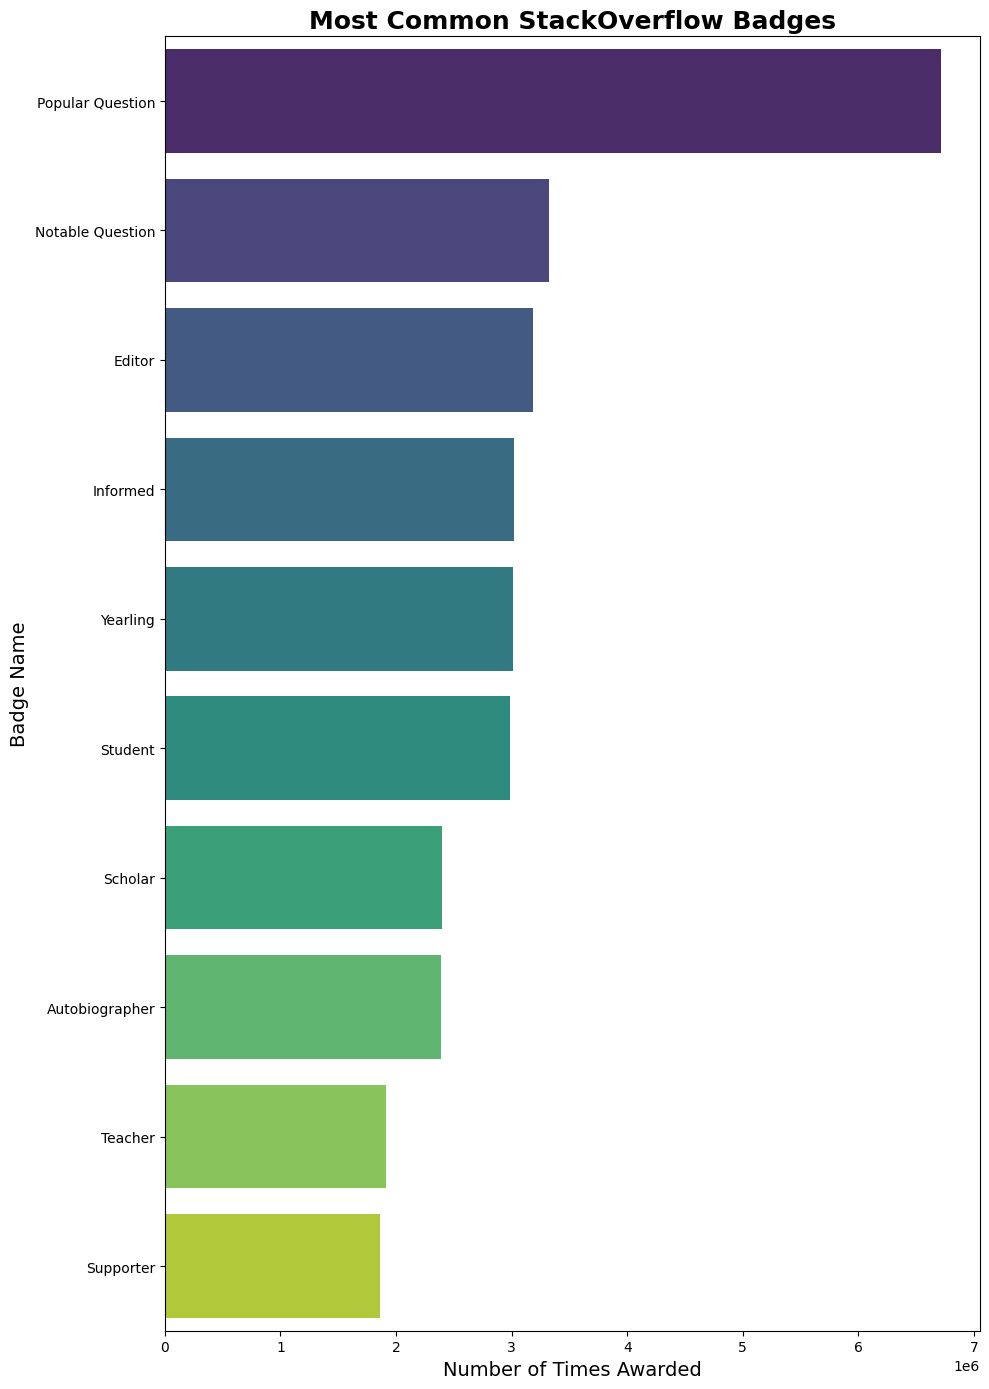

In [16]:
# Initialize client
client = bigquery.Client()

# Query badge counts
query = """
SELECT
  name,
  COUNT(*) AS badge_count
FROM `bigquery-public-data.stackoverflow.badges`
GROUP BY name
ORDER BY badge_count DESC
"""
df = client.query(query).to_dataframe()

# Plot 
plt.figure(figsize=(10, 14))

N = 10
df_top = df.head(N)

sns.barplot(
    data=df_top,
    y="name",
    x="badge_count",
    palette="viridis"  
)

plt.title("Most Common StackOverflow Badges", fontsize=18, fontweight="bold")
plt.xlabel("Number of Times Awarded", fontsize=14)
plt.ylabel("Badge Name", fontsize=14)

plt.tight_layout()
plt.show()


In [17]:
query = f"""
SELECT 
  user_id,
  name AS badge_name,
  date
FROM `bigquery-public-data.stackoverflow.badges`
WHERE user_id IN ({top_user_ids_str})
ORDER BY user_id, date
"""

df = stackOverflow.query_to_pandas_safe(query, max_gb_scanned=2)
df

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,user_id,badge_name,date
0,14122,Teacher,2008-09-16 23:22:31.490000+00:00
1,14122,Autobiographer,2008-09-17 00:07:32.320000+00:00
2,14122,Editor,2008-09-17 00:17:33.153000+00:00
3,14122,Supporter,2008-09-17 00:17:33.917000+00:00
4,14122,Critic,2008-09-17 04:17:32.593000+00:00
...,...,...,...
64211,3832970,Enlightened,2022-09-09 18:33:00.600000+00:00
64212,3832970,Nice Answer,2022-09-09 19:27:37.977000+00:00
64213,3832970,Enlightened,2022-09-09 21:26:37.303000+00:00
64214,3832970,Announcer,2022-09-20 13:22:29.083000+00:00


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


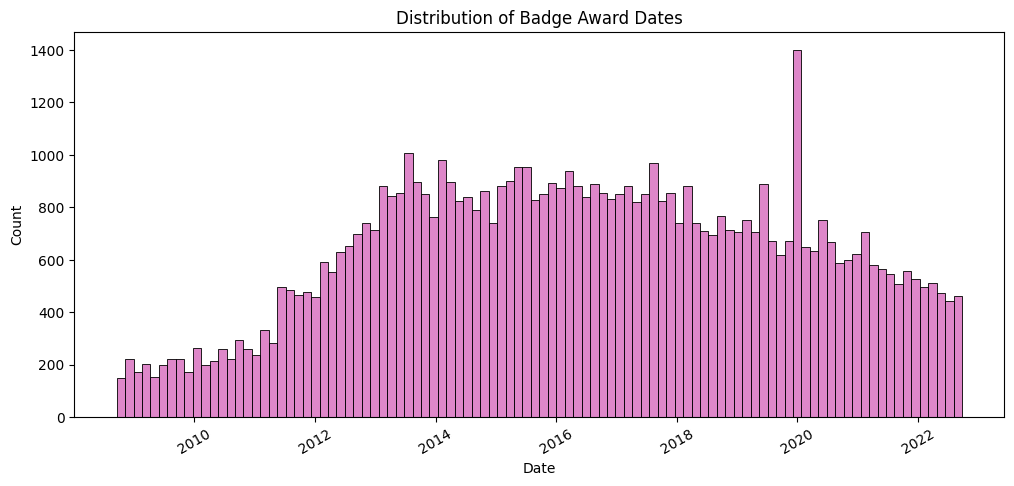

In [18]:
plt.figure(figsize=(12,5))
sns.histplot(df["date"], bins=100, color='#D35FB7', edgecolor='black')
plt.title("Distribution of Badge Award Dates")
plt.xlabel("Date")
plt.xticks(rotation=30)
plt.ylabel("Count")
plt.show()

Using Kaggle's public dataset BigQuery integration.


/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


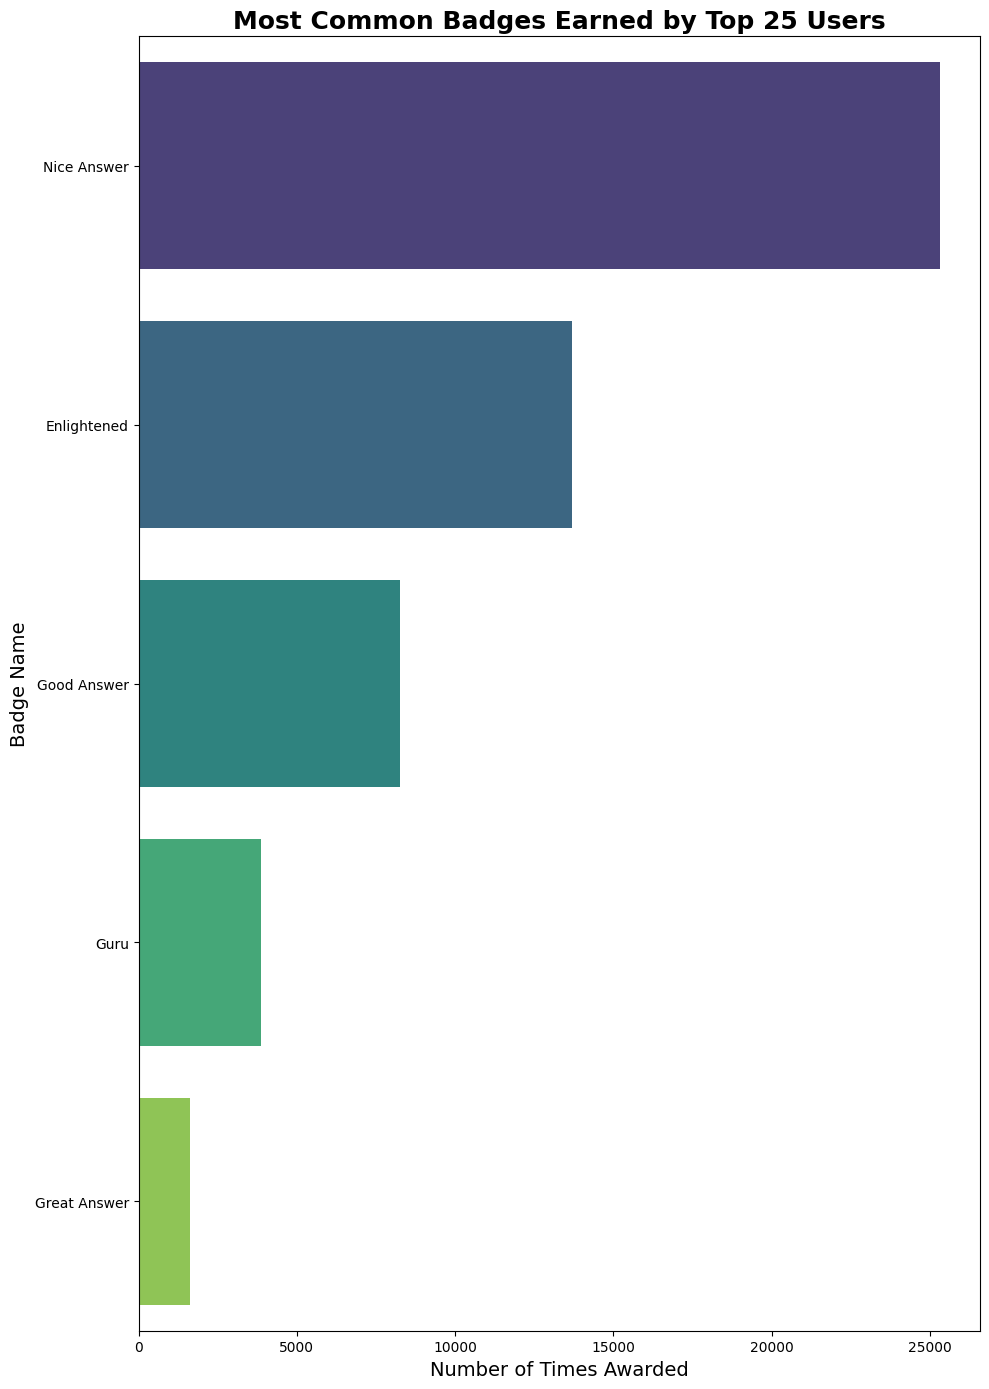

In [19]:
client = bigquery.Client()

top_user_ids_str = top_user_ids_str  

# Query: count badges for top 25 users 
query = f"""
SELECT
  name,
  COUNT(*) AS badge_count
FROM `bigquery-public-data.stackoverflow.badges`
WHERE user_id IN ({top_user_ids_str})
GROUP BY name
ORDER BY badge_count DESC
"""

df = client.query(query).to_dataframe()


plt.figure(figsize=(10, 14))

N = 5
df_top = df.head(N)

sns.barplot(
    data=df_top,
    y="name",
    x="badge_count",
    palette="viridis"
)

plt.title("Most Common Badges Earned by Top 25 Users", fontsize=18, fontweight="bold")
plt.xlabel("Number of Times Awarded", fontsize=14)
plt.ylabel("Badge Name", fontsize=14)

plt.tight_layout()
plt.show()


In [20]:
!pip install annoy

In [21]:
query = """
SELECT 
  users.id AS `User ID`,
  users.display_name AS `Display Name`, 
  users.location AS location,
  users.reputation AS Reputation,
  COUNT(comments.id) AS Count
FROM `bigquery-public-data.stackoverflow.users` AS users
INNER JOIN `bigquery-public-data.stackoverflow.comments` AS comments
  ON users.id = comments.user_id
WHERE users.id > 0
GROUP BY users.id, users.display_name, users.location, users.reputation
ORDER BY Count DESC
LIMIT 50000;
"""

users = stackOverflow.query_to_pandas_safe(query, max_gb_scanned=2)
users

/usr/local/lib/python3.11/dist-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,User ID,Display Name,location,Reputation,Count
0,1491895,Barmar,"Arlington, MA",694414,167475
1,22656,Jon Skeet,"Reading, United Kingdom",1357603,87006
2,1048572,Bergi,None,589324,79365
3,1144035,Gordon Linoff,"New York, United States",1211186,74579
4,440558,Some programmer dude,"Malmö, Sweden",385586,69749
...,...,...,...,...,...
49995,1574112,J2theC,None,4392,220
49996,11332797,Aaron,Germany,1480,220
49997,3762855,Ciro Corvino,"Verona, Italy",1908,219
49998,5026136,Elliptica,None,3300,219


In [22]:
# From Canvas
cities = pd.read_csv("/kaggle/input/cities/ScienceCityLatLong.csv")

In [23]:
# Cleanup + Fuzzy Algorithm from ChatGPT
# basic cleanup
users['location_clean'] = (
    users['location']
    .str.replace(r"<.*?>", "", regex=True)
    .str.replace(",", " ")
    .str.replace("|", " ")
    .str.strip()
)



In [24]:
users["location_clean"] = users["location_clean"].astype(str)
cities["City"] = cities["City"].astype(str)


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer="char",
    ngram_range=(2, 4),        # character n-grams works BEST for fuzzy matching
    min_df=2
)

city_embeddings = vectorizer.fit_transform(cities["City"])


In [26]:
import numpy as np
from annoy import AnnoyIndex

# convert sparse matrix to dense (OK for 1M x ~200 dims)
city_dense = city_embeddings.toarray()

dims = city_dense.shape[1]
index = AnnoyIndex(dims, metric="angular")

for i, vec in enumerate(city_dense):
    index.add_item(i, vec.tolist())

index.build(50)   # number of trees; 20–50 is good


True

In [27]:
user_embeddings = vectorizer.transform(users["location_clean"]).toarray()

In [ ]:
def fast_match(vec):
    idx = index.get_nns_by_vector(vec, 1)[0]  # closest match
    return cities.iloc[idx]["City"]

users["matched_city"] = [fast_match(v) for v in user_embeddings]

In [ ]:
users_geo = users.merge(
    cities,
    left_on="matched_city",
    right_on="City",
    how="left"
)


In [ ]:
city_counts = (
    users_geo.groupby(["matched_city", "Lat", "Lng"])
             .size()
             .reset_index(name="count")
)


In [ ]:
import plotly.express as px

# Cartopy would not work in Kaggle Notebook, so I used chatGPT to tweak plotly to look
 # like cartopy

fig = px.scatter_geo(
    city_counts,
    lat="Lat",
    lon="Lng",
    size="count",
    hover_name="matched_city",
    projection="natural earth"
)

# Update marker color and scale
fig.update_traces(
    marker=dict(
        color="pink",  # set point color
        sizemode="area",
        sizeref=4,       # adjust this to scale all points larger
        line=dict(width=0)
    )
)

# Update the background to black
fig.update_layout(
    geo=dict(
        bgcolor="black",        # sets the map background
        showland=True,
        landcolor="black",
        showocean=True,
        oceancolor="black",
        lakecolor="black",
        showlakes=True,
        showcountries=True,
        countrycolor="gray"
    ),
    paper_bgcolor="black",      # background outside the map
    plot_bgcolor="black"
)

fig.show()
fig.write_html("city_map.html")
